# Deep Neural Network for Image Classification: Application

**Problem Statement**:

 dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).
    We will reshape and standardize the images before feeding them to the network.


<center><img src="images/imvectorkiank.png" style="width:450px;height:300px;"></center>

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

We will build an L-layer deep neural network.

<center><img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;"></center>
<caption><center> <u>Figure 2</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, we take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, we take the sigmoid of the final linear unit. If it is greater than 0.5, we classify it to be a cat.

### General methodology

    1. Initialize parameters / Defining hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function(with L2 regularization in case of overfitting)
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

In [ ]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [14]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


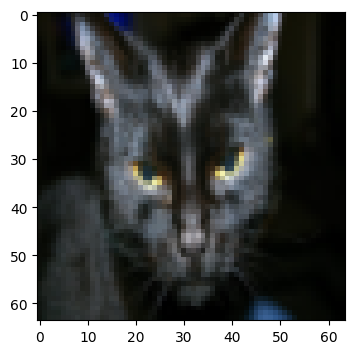

In [15]:
# Example of a picture
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [16]:
# Exploring the dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [17]:
# Reshaping the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardizing data to have feature values between 0 and 1.
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [18]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [19]:
import math

In [20]:
def initialize_parameters_deep_He(layers_dims):# He initialization
    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*math.sqrt(2./layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))*math.sqrt(2./layers_dims[l-1])
    return parameters

In [21]:
def compute_L2_regulized_cost(AL, Y, parameters, lambd):# we will set lambda != 0 in case of overfitting, otherwise no need for regularizing 
    
    m = AL.shape[1]
    L = len(parameters)//2
    cross_entropy_cost = -(1./m) * (np.dot(Y,np.log(AL).T)  + np.dot(1-Y, np.log(1-AL).T))
    norm_2_weights = 0
    
    for l in range (1, L):
        norm_2_weights += np.sum(np.square(parameters["W"+str(l)]))  
        
    L2_regularization_cost = lambd/(2*m)*norm_2_weights
    
    cost = cross_entropy_cost + L2_regularization_cost
    cost = np.squeeze(cost)     
    assert(cost.shape == ())
    
    return cost

In [22]:
def backward_propagation_with_regularization(AL, Y, caches, parameters, lambd):
    """
    Implements the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp 
        grads["dW" + str(l + 1)] = dW_temp + (lambd/m)*parameters["W"+str(l+1)]
        grads["db" + str(l + 1)] = db_temp

    return grads

In [23]:
# L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0077, num_iterations = 3000, print_cost=False, lambd = 0):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keeping track of cost to plot it later on
    
    # Parameters initialization. 
    parameters = initialize_parameters_deep_He(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Computing cost.
        cost = compute_L2_regulized_cost(AL, Y, parameters, lambd)
    
        # Backward propagation.
        grads = backward_propagation_with_regularization(AL, Y, caches, parameters, lambd)
 
        # Updating parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Printing the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plotting the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 1.208125
Cost after iteration 100: 0.673659
Cost after iteration 200: 0.662022
Cost after iteration 300: 0.654774
Cost after iteration 400: 0.650083
Cost after iteration 500: 0.646981
Cost after iteration 600: 0.644628
Cost after iteration 700: 0.642787
Cost after iteration 800: 0.641139
Cost after iteration 900: 0.639565
Cost after iteration 1000: 0.636716
Cost after iteration 1100: 0.634691
Cost after iteration 1200: 0.632644
Cost after iteration 1300: 0.629856
Cost after iteration 1400: 0.626556
Cost after iteration 1500: 0.622730
Cost after iteration 1600: 0.619420
Cost after iteration 1700: 0.614468
Cost after iteration 1800: 0.585950
Cost after iteration 1900: 0.558121
Cost after iteration 2000: 0.525345
Cost after iteration 2100: 0.472339
Cost after iteration 2200: 0.441173
Cost after iteration 2300: 0.378895
Cost after iteration 2400: 0.357973
Cost after iteration 2500: 0.554498
Cost after iteration 2600: 0.342662
Cost after iteration 2700: 0.463615
Cost

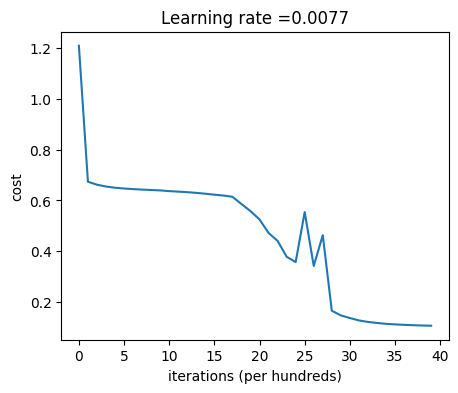

In [24]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations= 4000, print_cost = True, lambd = 0)

In [28]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9760765550239232


In [30]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8200000000000001


### We ended up with a 4_layer deep neural network implemented from scratch and that predicts 82% of the test set images' classes correctly.

Accuracy: 1.0
y = 1.0, my L-layer model predicts a "cat" picture.


C:\Users\HP\AppData\Local\Temp\ipykernel_115912\3917005335.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  fileImage = Image.open("test.png").convert("RGB").resize([num_px,num_px],Image.ANTIALIAS)


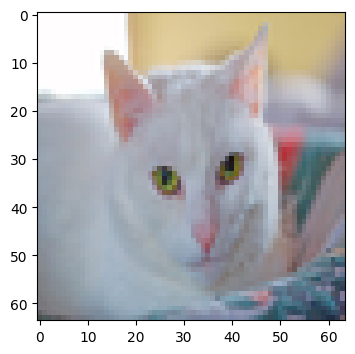

In [31]:
from PIL import Image

fileImage = Image.open("test.png").convert("RGB").resize([num_px,num_px],Image.ANTIALIAS)
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

image = np.array(fileImage)
my_image = image.reshape(num_px*num_px*3,1)
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", my L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")